<img src="../src/packt-banner.png" alt="">

# Chapter 1: Model Validation and Optimization

We continue where `chapter_4_workbook.ipynb` left off, by loading the processed Human Resource Analytics dataset and exploring more advanced methods for training models with scikit-learn. We implement k-fold cross validation strategies, and lean about PCA dimensionality reduction.

---

In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['axes.labelpad'] = 10
sns.set_style("darkgrid")

In [2]:
%load_ext watermark
%watermark -d -v -m -p requests,numpy,pandas,matplotlib,seaborn,sklearn

2020-02-16 

CPython 3.7.5
IPython 7.10.1

requests 2.22.0
numpy 1.17.4
pandas 0.25.3
matplotlib 3.1.1
seaborn 0.9.0
sklearn 0.21.3

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


---

## Model selection techniques

We start using model selection techniques to optimize classification models.

---

### K-fold cross validation

---

In [3]:
# Load the processed data

df = pd.read_csv('../data/hr-analytics/hr_data_processed.csv')

In [4]:
# Select training / validation and test set

from sklearn.model_selection import train_test_split

features = ['satisfaction_level', 'last_evaluation']
X, X_test, y, y_test = train_test_split(
    df[features].values,
    df['left'].values,
    test_size=0.15,
    random_state=1
)

In [5]:
# Instantiate the model

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=5)

In [6]:
# Stratified k-fold cross validation

from sklearn.model_selection import cross_val_score

np.random.seed(1)
scores = cross_val_score(
    estimator=clf,
    X=X,
    y=y,
    cv=10,
)

print('accuracy = {:.3f} +/- {:.3f}'.format(
    scores.mean(),
    scores.std(),
))

accuracy = 0.923 +/- 0.006


In [7]:
# Custom function for class accuracies

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

def cross_val_class_score(clf, X, y, cv=10):
    kfold = (
        StratifiedKFold(n_splits=cv)
        .split(X, y)
    )
    class_accuracy = []
    for k, (train, test) in enumerate(kfold):
        clf.fit(X[train], y[train])
        y_test = y[test]
        y_pred = clf.predict(X[test])
        cmat = confusion_matrix(y_test, y_pred)
        class_acc = cmat.diagonal()/cmat.sum(axis=1)
        class_accuracy.append(class_acc)
        print('fold: {:d} accuracy: {:s}'.format(
            k+1,
            str(class_acc),
        ))
        
    return np.array(class_accuracy)

In [8]:
# Stratified k-fold cross validation

np.random.seed(1)
scores = cross_val_class_score(clf, X, y)

print('accuracy = {} +/- {}'.format(
    scores.mean(axis=0),
    scores.std(axis=0),
))

fold: 1 accuracy: [0.98559671 0.72039474]
fold: 2 accuracy: [0.98559671 0.68976898]
fold: 3 accuracy: [0.98971193 0.72937294]
fold: 4 accuracy: [0.98765432 0.74257426]
fold: 5 accuracy: [0.99074074 0.71617162]
fold: 6 accuracy: [0.98971193 0.72607261]
fold: 7 accuracy: [0.98251029 0.68976898]
fold: 8 accuracy: [0.98559671 0.69306931]
fold: 9 accuracy: [0.98455201 0.72277228]
fold: 10 accuracy: [0.98352214 0.74917492]
accuracy = [0.98651935 0.71791406] +/- [0.00266409 0.0200439 ]


---

### Validation curves
---

In [9]:
# Calcualte a validation curve

from sklearn.model_selection import validation_curve

clf = DecisionTreeClassifier()
max_depth_range = np.arange(3, 20, 1)

np.random.seed(1)
train_scores, test_scores = validation_curve(
    estimator=clf,
    X=X,
    y=y,
    param_name='max_depth',
    param_range=max_depth_range,
    cv=5,
);

In [10]:
# Function to draw the validation curve

def plot_validation_curve(
    train_scores,
    test_scores,
    param_range,
    xlabel='',
    log=False,
):
    """This code is from scikit-learn docs (BSD License).
    
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    fig = plt.figure()
    
    plt.plot(param_range, train_mean, 
             color=sns.color_palette('Set1')[1], marker='o', 
             markersize=5, label='training accuracy')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color=sns.color_palette('Set1')[1])

    plt.plot(param_range, test_mean, 
             color=sns.color_palette('Set1')[0], linestyle='--', 
             marker='s', markersize=5, 
             label='validation accuracy')

    plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color=sns.color_palette('Set1')[0])

    if log:
        plt.xscale('log')
    plt.legend(loc='lower right')
    if xlabel:
        plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.ylim(0.9, 1.0)
    return fig

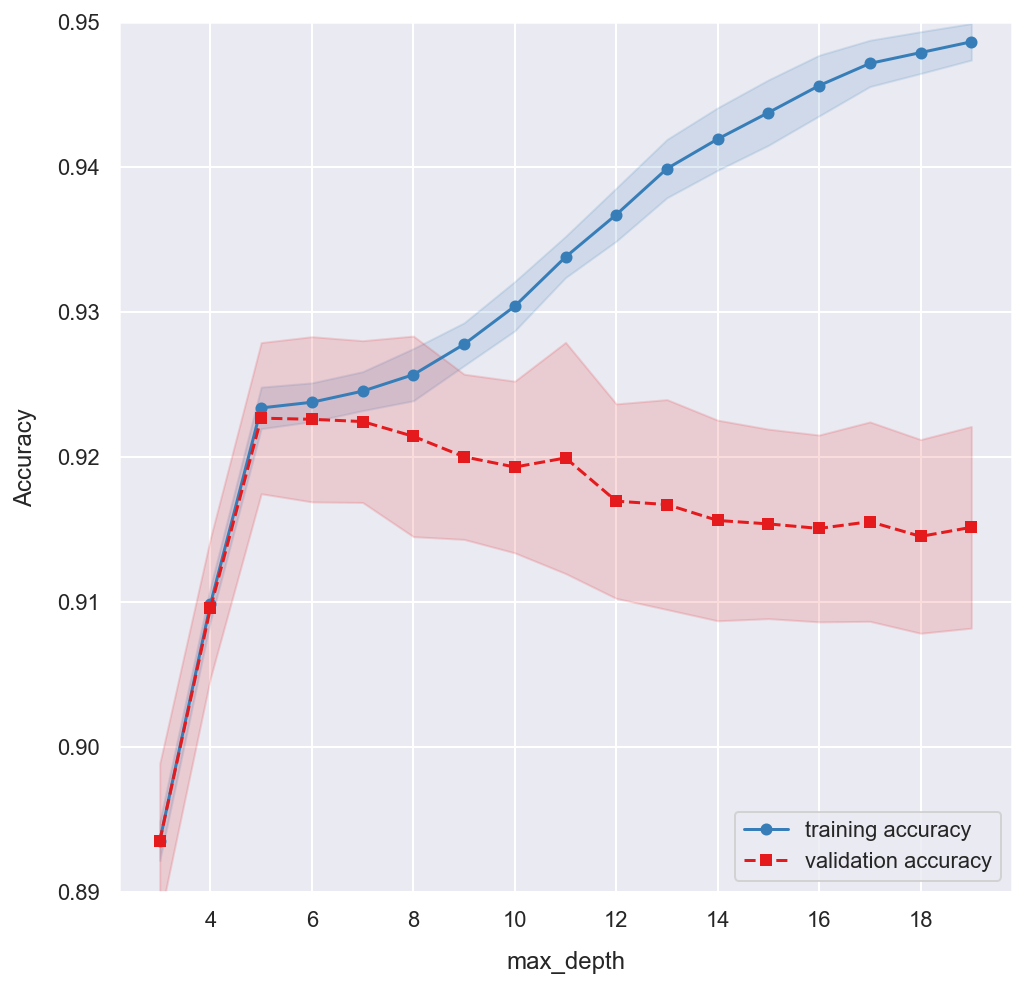

In [11]:
plot_validation_curve(
    train_scores,
    test_scores,
    max_depth_range,
    xlabel='max_depth',
)
plt.ylim(0.89, 0.95)
plt.savefig(
    '../figures/chapter-5-hr-analytics-val-curve-model-1.png',
    bbox_inches='tight',
    dpi=300,
)

---

### Dimensionality Reduction with PCA

---

In [12]:
# Load the processed data

df = pd.read_csv('../data/hr-analytics/hr_data_processed.csv')
print(df.columns)

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department_IT', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'department_sales',
       'department_support', 'department_technical', 'salary_high',
       'salary_low', 'salary_medium'],
      dtype='object')


In [13]:
# Train a "quick and dirty" decision tree

features = [
    'satisfaction_level', 'last_evaluation', 'number_project',
    'average_montly_hours', 'time_spend_company', 'work_accident',
    'promotion_last_5years', 'department_IT', 'department_RandD',
    'department_accounting', 'department_hr', 'department_management',
    'department_marketing', 'department_product_mng', 'department_sales',
    'department_support', 'department_technical', 'salary_high',
    'salary_low', 'salary_medium'
]

X = df[features].values
y = df.left.values

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=10)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

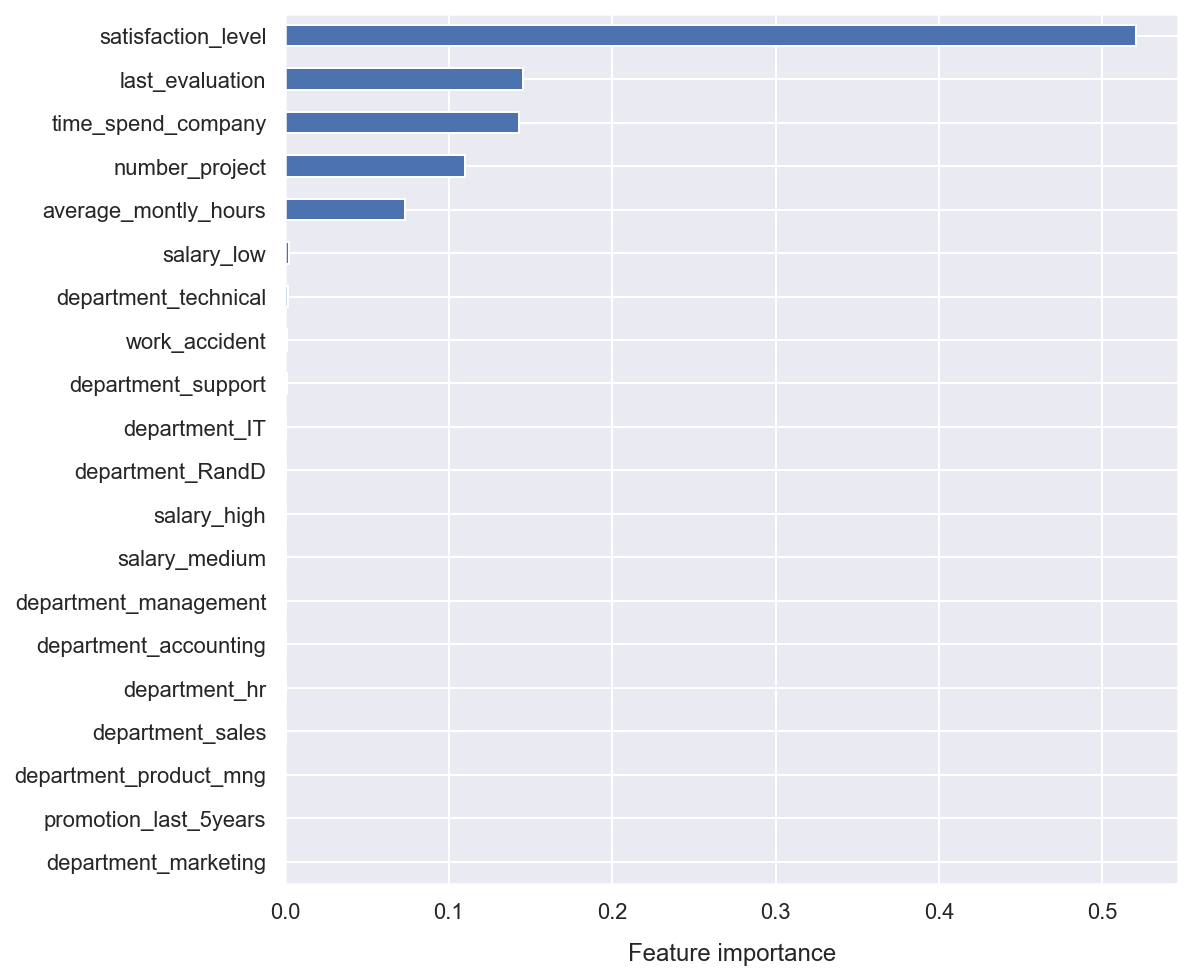

In [14]:
# Visualize the feature importances

(
    pd.Series(
        clf.feature_importances_,
        name='Feature importance',
        index=df[features].columns,
    )
    .sort_values()
    .plot.barh()
)
plt.xlabel('Feature importance')
plt.savefig(
    '../figures/chapter-5-hr-analytics-feature-imp-model-2.png',
    bbox_inches='tight',
    dpi=300,
)

In [15]:
# Select features with low / high importance

importances = list(
    pd.Series(
        clf.feature_importances_,
        index=df[features].columns,
    )
    .sort_values(ascending=False).index
)
low_importance_features = importances[5:]
high_importance_features = importances[:5]

In [16]:
np.array(low_importance_features)

array(['salary_low', 'department_technical', 'work_accident',
       'department_support', 'department_IT', 'department_RandD',
       'salary_high', 'salary_medium', 'department_management',
       'department_accounting', 'department_hr', 'department_sales',
       'department_product_mng', 'promotion_last_5years',
       'department_marketing'], dtype='<U22')

In [17]:
np.array(high_importance_features)

array(['satisfaction_level', 'last_evaluation', 'time_spend_company',
       'number_project', 'average_montly_hours'], dtype='<U20')

In [18]:
# Reduce the one-hot-encoded features with PCA

from sklearn.decomposition import PCA

pca_features = [
    'salary_low', 'department_technical', 'department_support',
    'work_accident', 'salary_medium', 'department_IT',
    'department_RandD', 'salary_high', 'department_management',
    'department_accounting', 'department_hr', 'department_sales',
    'department_product_mng', 'promotion_last_5years',
    'department_marketing'
]

X_reduce = df[pca_features]

pca = PCA(n_components=3)
pca.fit(X_reduce)
X_pca = pca.transform(X_reduce)

In [19]:
X_pca.shape

(14999, 3)

In [20]:
# Add principal components to df

df['first_principle_component'] = X_pca.T[0]
df['second_principle_component'] = X_pca.T[1]
df['third_principle_component'] = X_pca.T[2]

In [21]:
# Save the pca data

df.to_csv(
    '../data/hr-analytics/hr_data_processed_pca.csv',
    index=False,
)

In [22]:
# Save the PCA transformer

import joblib
joblib.dump(pca, 'hr-analytics-pca.pkl')

['hr-analytics-pca.pkl']

---

### Training a Production Ready Model for Employee Turnover

---

In [23]:
# Load the processed data

df = pd.read_csv('../data/hr-analytics/hr_data_processed_pca.csv')
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department_IT', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'department_sales',
       'department_support', 'department_technical', 'salary_high',
       'salary_low', 'salary_medium', 'first_principle_component',
       'second_principle_component', 'third_principle_component'],
      dtype='object')

In [24]:
# Select training / validation and test set

from sklearn.model_selection import train_test_split

features = [
    'satisfaction_level', 'last_evaluation', 'time_spend_company',
    'number_project', 'average_montly_hours',
    'first_principle_component',
    'second_principle_component',
    'third_principle_component',
]
X, X_test, y, y_test = train_test_split(
    df[features].values,
    df['left'].values,
    test_size=0.15,
    random_state=1
)

In [25]:
%%time
# Calculate a validation curve for max_depth
# using a DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier

np.random.seed(1)
clf = DecisionTreeClassifier()
max_depth_range = np.arange(2, 52, 2)
print('Training {} models ...'.format(len(max_depth_range)))
train_scores, test_scores = validation_curve(
    estimator=clf,
    X=X,
    y=y,
    param_name='max_depth',
    param_range=max_depth_range,
    cv=10,
);

Training 25 models ...
CPU times: user 8.1 s, sys: 51.5 ms, total: 8.15 s
Wall time: 8.21 s


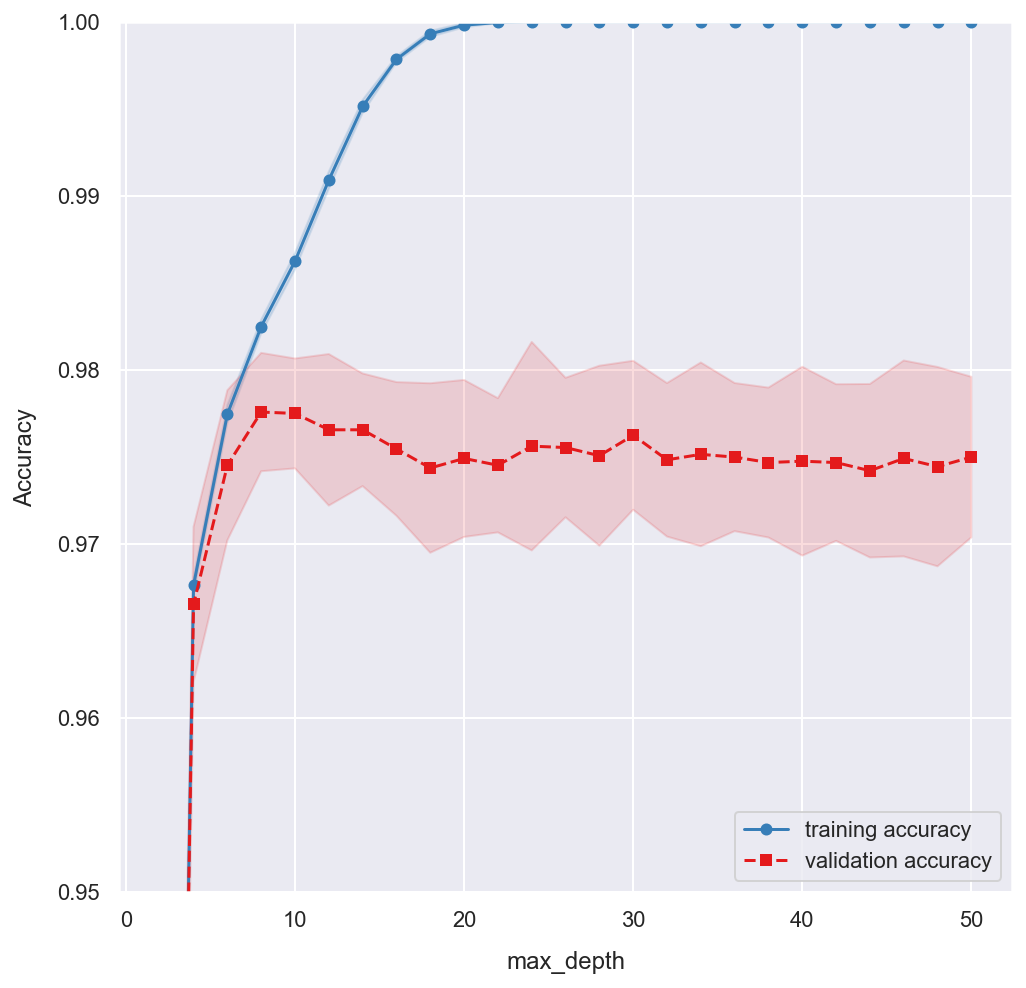

In [26]:
# Draw the validation curve

plot_validation_curve(
    train_scores,
    test_scores,
    max_depth_range,
    xlabel='max_depth',
)
plt.ylim(0.95, 1.0)
plt.savefig(
    '../figures/chapter-5-hr-analytics-val-curve-pca-tree.png',
    bbox_inches='tight',
    dpi=300,
)

In [27]:
# Show k-fold results for the selected model:
# a decision tree with max_depth = 8

clf = DecisionTreeClassifier(max_depth=8)
np.random.seed(1)
scores = cross_val_class_score(clf, X, y)

print('accuracy = {} +/- {}'.format(
    scores.mean(axis=0),
    scores.std(axis=0),
))

fold: 1 accuracy: [0.99382716 0.91118421]
fold: 2 accuracy: [0.99588477 0.91089109]
fold: 3 accuracy: [0.99897119 0.91749175]
fold: 4 accuracy: [0.99588477 0.95379538]
fold: 5 accuracy: [0.99279835 0.91419142]
fold: 6 accuracy: [0.99588477 0.92079208]
fold: 7 accuracy: [0.99485597 0.92409241]
fold: 8 accuracy: [0.99382716 0.9339934 ]
fold: 9 accuracy: [0.9907312  0.91419142]
fold: 10 accuracy: [0.99176107 0.94059406]
accuracy = [0.99444264 0.92412172] +/- [0.00226594 0.01357943]


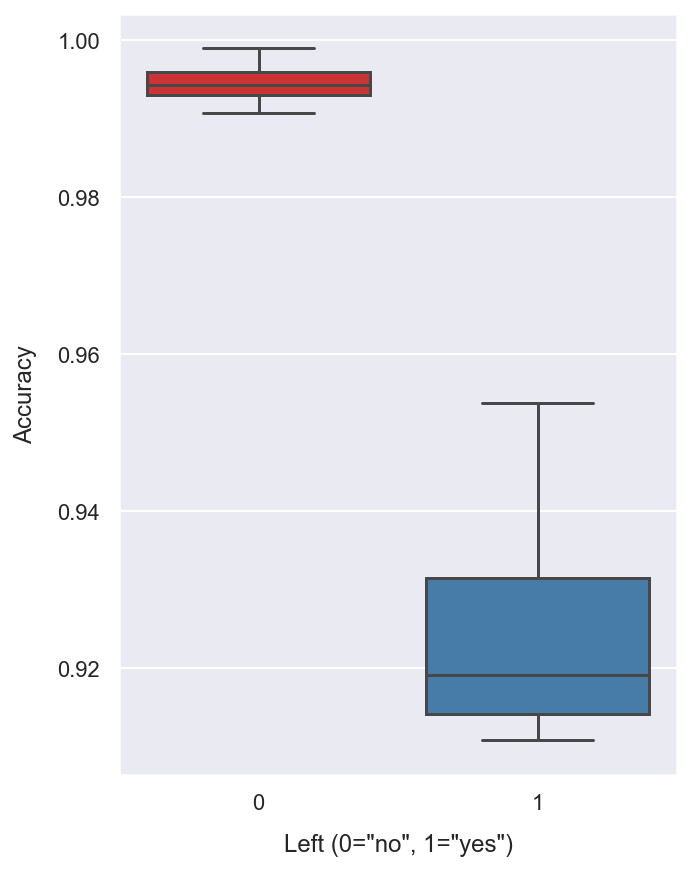

In [28]:
# Box plot of result

fig = plt.figure(figsize=(5, 7))
sns.boxplot(
    data=pd.DataFrame(scores, columns=[0, 1]),
    palette=sns.color_palette('Set1'),
)
plt.xlabel('Left (0="no", 1="yes")')
plt.ylabel('Accuracy')
plt.savefig(
    '../figures/chapter-5-hr-analytics-kfold-pca-tree.png',
    bbox_inches='tight',
    dpi=300,
)

In [29]:
# Evaluate performance on the test set

from sklearn.metrics import confusion_matrix

clf = DecisionTreeClassifier(max_depth=8)
clf.fit(X, y)

y_pred = clf.predict(X_test)
cmat = confusion_matrix(y_test, y_pred)
cmat.diagonal() / cmat.sum(axis=1) * 100

array([99.23976608, 93.88888889])

In [30]:
# Train the final model on all the samples

features = [
    'satisfaction_level', 'last_evaluation', 'time_spend_company',
    'number_project', 'average_montly_hours',
    'first_principle_component',
    'second_principle_component',
    'third_principle_component',
]
X = df[features].values
y = df['left'].values

clf = DecisionTreeClassifier(max_depth=8)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [31]:
# Save the model

import joblib
joblib.dump(clf, 'hr-analytics-pca-tree.pkl')

['hr-analytics-pca-tree.pkl']

In [32]:
# Check that it saved to the working directory

!ls .

chapter_5_workbook.ipynb    hr-analytics-pca-tree.pkl
hr-analytics-pca-forest.pkl hr-analytics-pca.pkl


In [33]:
# Load the saved model

clf = joblib.load('hr-analytics-pca-tree.pkl')
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [34]:
# Print an example 

pca_features = [
    'salary_low', 'department_technical', 'work_accident',
    'department_support', 'department_IT', 'department_RandD',
    'salary_high', 'salary_medium', 'department_management',
    'department_accounting', 'department_hr', 'department_sales',
    'department_product_mng', 'promotion_last_5years',
    'department_marketing'
]

non_pca_features = [
    'satisfaction_level', 'last_evaluation', 'time_spend_company',
    'number_project', 'average_montly_hours'
]

bob = df.iloc[8483][pca_features + non_pca_features]
bob

salary_low                  1.00
department_technical        0.00
work_accident               0.00
department_support          0.00
department_IT               0.00
department_RandD            0.00
salary_high                 0.00
salary_medium               0.00
department_management       0.00
department_accounting       0.00
department_hr               0.00
department_sales            1.00
department_product_mng      0.00
promotion_last_5years       0.00
department_marketing        0.00
satisfaction_level          0.77
last_evaluation             0.68
time_spend_company          2.00
number_project              3.00
average_montly_hours      225.00
Name: 8483, dtype: float64

In [35]:
# Load and apply PCA transformation

pca = joblib.load('hr-analytics-pca.pkl')
pca_feature_values = pca.transform([bob[pca_features]])[0]
pca_feature_values

array([-0.67733089,  0.75837169, -0.10493685])

In [36]:
# Create prediction vector for Bob

X_bob = np.concatenate((bob[non_pca_features].values, pca_feature_values))
X_bob

array([ 7.70000000e-01,  6.80000000e-01,  2.00000000e+00,  3.00000000e+00,
        2.25000000e+02, -6.77330887e-01,  7.58371688e-01, -1.04936853e-01])

In [37]:
# Does the model predict that Bob will leave?

clf.predict([X_bob])

array([0])

In [38]:
# How confident is the model in this prediction?

clf.predict_proba([X_bob])

array([[0.98462639, 0.01537361]])

---

### Activity: Hyperparameter Tuning and Model Selection

---

In [39]:
# Load the processed data

df = pd.read_csv('../data/hr-analytics/hr_data_processed_pca.csv')
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department_IT', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'department_sales',
       'department_support', 'department_technical', 'salary_high',
       'salary_low', 'salary_medium', 'first_principle_component',
       'second_principle_component', 'third_principle_component'],
      dtype='object')

In [40]:
# Select training / validation and test set

from sklearn.model_selection import train_test_split

features = [
    'satisfaction_level', 'last_evaluation', 'time_spend_company',
    'number_project', 'average_montly_hours',
    'first_principle_component',
    'second_principle_component',
    'third_principle_component',
]
X, X_test, y, y_test = train_test_split(
    df[features].values,
    df['left'].values,
    test_size=0.15,
    random_state=1
)

In [41]:
# Calculate a validation curve for max_depth
# using a RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

np.random.seed(1)
clf = RandomForestClassifier(n_estimators=50)
max_depth_range = np.arange(2, 52, 2)
print('Training {} models ...'.format(len(max_depth_range)))
train_scores, test_scores = validation_curve(
    estimator=clf,
    X=X,
    y=y,
    param_name='max_depth',
    param_range=max_depth_range,
    cv=5,
);

Training 25 models ...


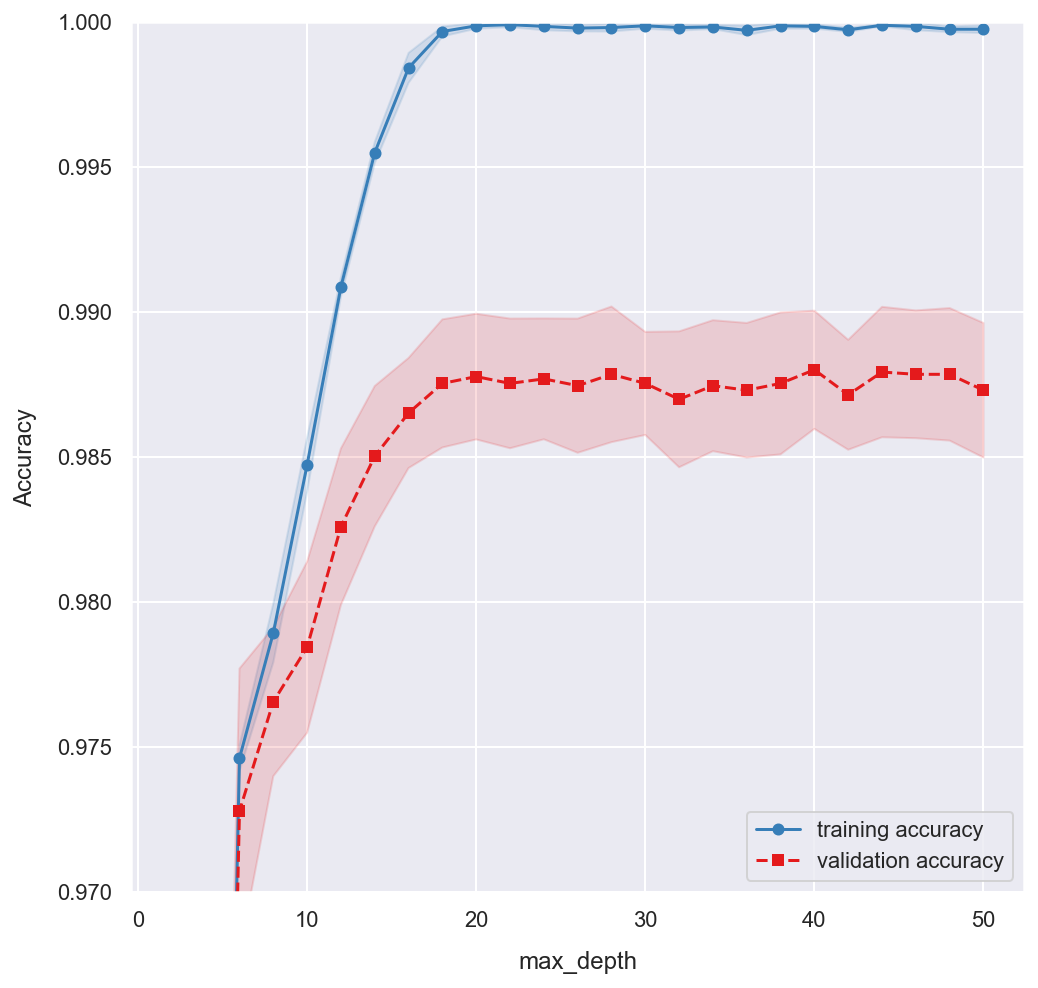

In [42]:
# Draw the validation curve

plot_validation_curve(
    train_scores,
    test_scores,
    max_depth_range,
    xlabel='max_depth',
)
plt.ylim(0.97, 1.0)
plt.savefig(
    '../figures/chapter-5-hr-analytics-val-curve-pca-forest.png',
    bbox_inches='tight',
    dpi=300,
)

In [43]:
# Show k-fold results for the selected model:
# a random forest with max_depth = 25

clf = RandomForestClassifier(n_estimators=50, max_depth=25)
np.random.seed(1)
scores = cross_val_class_score(clf, X, y)

print('accuracy = {} +/- {}'.format(
    scores.mean(axis=0),
    scores.std(axis=0),
))

fold: 1 accuracy: [0.99897119 0.94407895]
fold: 2 accuracy: [0.99897119 0.96369637]
fold: 3 accuracy: [0.99897119 0.96039604]
fold: 4 accuracy: [0.99794239 0.98349835]
fold: 5 accuracy: [0.99897119 0.96039604]
fold: 6 accuracy: [0.99691358 0.95379538]
fold: 7 accuracy: [0.99794239 0.95709571]
fold: 8 accuracy: [0.99897119 0.95709571]
fold: 9 accuracy: [0.9969104  0.94059406]
fold: 10 accuracy: [0.99485067 0.97689769]
accuracy = [0.99794154 0.95975443] +/- [0.00130286 0.01239563]


In [44]:
# Evaluate performance on test set

from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(n_estimators=50, max_depth=25)
clf.fit(X, y)

y_pred = clf.predict(X_test)
cmat = confusion_matrix(y_test, y_pred)
cmat.diagonal() / cmat.sum(axis=1) * 100

array([99.70760234, 97.03703704])

In [45]:
# Train the final model on all the samples

features = [
    'satisfaction_level', 'last_evaluation', 'time_spend_company',
    'number_project', 'average_montly_hours',
    'first_principle_component',
    'second_principle_component',
    'third_principle_component',
]
X = df[features].values
y = df['left'].values

clf = RandomForestClassifier(n_estimators=50, max_depth=25)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [46]:
# Save the model

import joblib
joblib.dump(clf, 'hr-analytics-pca-forest.pkl')

['hr-analytics-pca-forest.pkl']

In [48]:
# Load model from pkl file

clf = joblib.load('hr-analytics-pca-forest.pkl')
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [49]:
# Example of using the model for a specific employee

alice = df.iloc[573][features]
alice

satisfaction_level              0.360000
last_evaluation                 0.470000
time_spend_company              3.000000
number_project                  2.000000
average_montly_hours          148.000000
first_principle_component       0.742801
second_principle_component     -0.514568
third_principle_component      -0.677421
Name: 573, dtype: float64

In [50]:
# Predict the class label for Alice

clf.predict([alice.values])

array([1])

In [51]:
# Predict the probability of class labels for Alice

clf.predict_proba([alice.values])

array([[0., 1.]])

In [52]:
# What if we reduce her number of hours and time spent at the company?

alice.average_montly_hours = 100
alice.time_spend_company = 2
clf.predict_proba([alice.values])

array([[0.84, 0.16]])

In [53]:
clf.predict([alice.values])

array([0])

---